In [1]:

import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import residual_GAN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# discriminator

In [3]:
discriminator = residual_GAN.Discriminator().to(device)

In [4]:
discriminator.load_state_dict(torch.load(r"resnet_300M\run11\discriminator.pth"))

<All keys matched successfully>

# generator

In [5]:
generator = residual_GAN.Generator(noise_dim=2048).to(device)

In [6]:
generator.load_state_dict(torch.load(r"resnet_300M\run11\generator.pth"))

<All keys matched successfully>

# other utilities

In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=5e-4)

In [7]:
def noise_generator(device,batch_size=64, dimension=2048):
    return torch.randn((batch_size, dimension)).to(device)

# data pipeline

In [9]:
img_transforms = transforms.Compose([
    transforms.Resize([128,128]),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [10]:
folder = "../../Datasets/annotated_img/images/train2017"

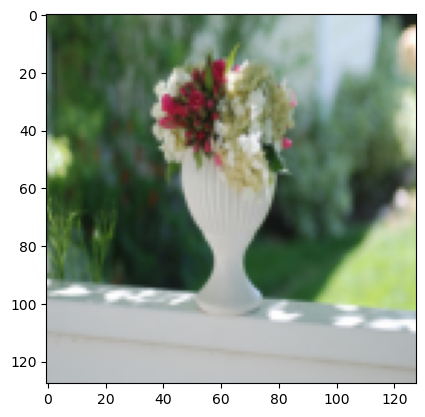

In [11]:
image = folder + "/000000000030.jpg"
image = Image.open(image).convert("RGB")
image_transformed = img_transforms(image)
plt.imshow(np.array(image_transformed).transpose(1,2,0))

In [12]:
from image_dataset import image_dataset

In [13]:
train_dataset = image_dataset(folder,img_transforms)

In [14]:
len(train_dataset)

118287

In [15]:
from torch.utils.data import RandomSampler
batch_size = 64
num_samples = 19200
train_sampler = RandomSampler(train_dataset,replacement=False,num_samples=num_samples)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,sampler=train_sampler)

# training routine

In [16]:
from torch_snippets import *

In [17]:

model_name = "resnet_300M"
if not os.path.exists(model_name):
    os.makedirs(model_name)


In [18]:
def train_discriminator(discriminator, real_data, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_real = discriminator(real_data)
    loss_real = loss_fn(pred_real, torch.ones((len(real_data),1)).to(device))
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake, torch.zeros((len(fake_data),1)).to(device))
    loss = loss_real * 3 + loss_fake
    loss.backward()
    optimizer.step()
    return loss_real, loss_fake

In [19]:
def train_generator(discriminator, fake_data, loss_fn, optimizer):
    optimizer.zero_grad()
    pred_fake = discriminator(fake_data)
    loss_fake = loss_fn(pred_fake,torch.ones((len(fake_data),1)).to(device))
    loss_fake.backward()
    optimizer.step()
    return loss_fake

In [20]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-5)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=7e-5)

EPOCH: 1.000  d_loss: 0.798  d_real_loss: 0.173  d_fake_loss: 0.626  g_loss: 1.218  (251.69s - 2265.23s remaining)
EPOCH: 2.000  d_loss: 0.935  d_real_loss: 0.192  d_fake_loss: 0.743  g_loss: 1.044  (500.96s - 2003.82s remaining)
EPOCH: 3.000  d_loss: 0.996  d_real_loss: 0.202  d_fake_loss: 0.794  g_loss: 1.034  (750.18s - 1750.43s remaining)
EPOCH: 4.000  d_loss: 1.001  d_real_loss: 0.194  d_fake_loss: 0.807  g_loss: 1.017  (999.25s - 1498.88s remaining)
EPOCH: 5.000  d_loss: 1.016  d_real_loss: 0.201  d_fake_loss: 0.815  g_loss: 1.089  (1248.59s - 1248.59s remaining)
EPOCH: 6.000  d_loss: 1.081  d_real_loss: 0.232  d_fake_loss: 0.849  g_loss: 1.005  (1499.00s - 999.33s remaining))
EPOCH: 7.000  d_loss: 1.106  d_real_loss: 0.230  d_fake_loss: 0.876  g_loss: 0.801  (1748.26s - 749.25s remaining)
EPOCH: 8.000  d_loss: 0.973  d_real_loss: 0.183  d_fake_loss: 0.790  g_loss: 0.980  (1996.88s - 499.22s remaining)
EPOCH: 9.000  d_loss: 1.103  d_real_loss: 0.214  d_fake_loss: 0.890  g_loss: 0

100%|██████████| 111/111 [00:00<00:00, 1154.01it/s]


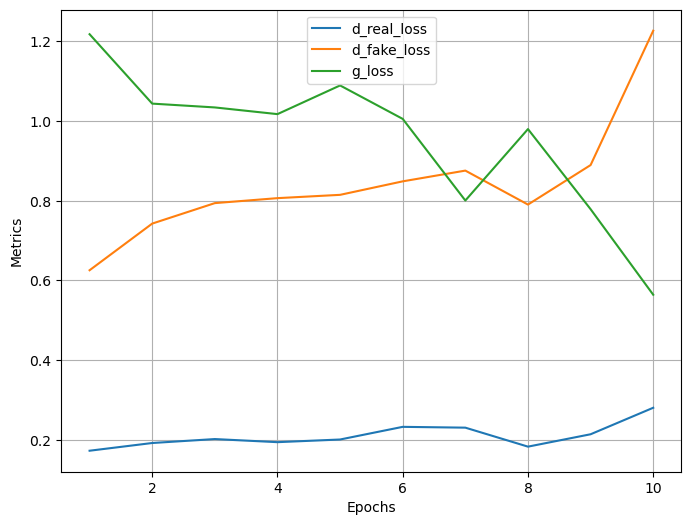

In [21]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 10
threshold = 2.3
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
loss_total = 0
num_batchs = 0
count = 0
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        g_d_loss = g_loss.item() + d_real.item() + d_fake.item()
        loss_total += g_d_loss
        num_batchs += 1
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(), total_loss = g_d_loss,
                   end = '\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        torch.save(generator.state_dict(),model_name+"/generator.pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
        count = 0
    else:
        count += 1
        if count >= 3:
            break
    loss_total = 0
    num_batchs = 0

log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])

In [22]:
# d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-5)
# g_optimizer = torch.optim.AdamW(generator.parameters(),lr=7e-5)

In [18]:
# generator.load_state_dict(torch.load("resnet_300M\generator.pth"))
# discriminator.load_state_dict(torch.load("resnet_300M\discriminator.pth"))

<All keys matched successfully>

EPOCH: 1.000  d_loss: 1.214  g_loss: 0.886  d_real_loss: 0.230  d_fake_loss: 0.984  total_loss: 2.100  (246.05s - 4675.04s remaining)
EPOCH: 2.000  d_loss: 1.103  g_loss: 0.903  d_real_loss: 0.210  d_fake_loss: 0.893  total_loss: 2.006  (492.91s - 4436.16s remaining)
EPOCH: 3.000  d_loss: 1.231  g_loss: 0.806  d_real_loss: 0.236  d_fake_loss: 0.995  total_loss: 2.037  (773.17s - 4381.31s remaining)
EPOCH: 4.000  d_loss: 1.196  g_loss: 0.843  d_real_loss: 0.226  d_fake_loss: 0.970  total_loss: 2.039  (1065.74s - 4262.95s remaining)
EPOCH: 5.000  d_loss: 1.104  g_loss: 0.859  d_real_loss: 0.214  d_fake_loss: 0.891  total_loss: 1.963  (1323.85s - 3971.54s remaining)
EPOCH: 6.000  d_loss: 1.050  g_loss: 0.890  d_real_loss: 0.218  d_fake_loss: 0.831  total_loss: 1.940  (1571.50s - 3666.84s remaining)
EPOCH: 7.000  d_loss: 1.032  g_loss: 1.121  d_real_loss: 0.203  d_fake_loss: 0.830  total_loss: 2.154  (1818.63s - 3377.46s remaining)
EPOCH: 8.000  d_loss: 0.815  g_loss: 1.141  d_real_loss: 0

100%|██████████| 121/121 [00:00<00:00, 572.90it/s]


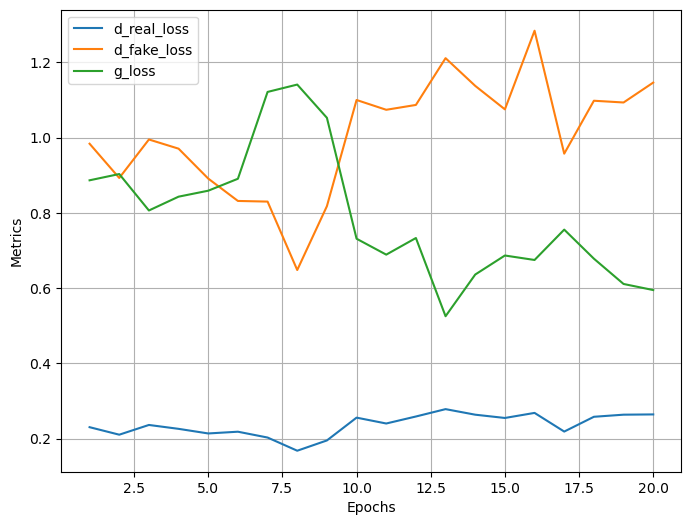

In [22]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 20
threshold = 2.2
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
loss_total = 0
num_batchs = 0
count = 0
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        g_d_loss = g_loss.item() + d_real.item() + d_fake.item()
        loss_total += g_d_loss
        num_batchs += 1
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(), total_loss = g_d_loss,
                   end = '\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        torch.save(generator.state_dict(),model_name+"/generator.pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
        count = 0
    else:
        count += 1
        if count >= 3:
            break
    loss_total = 0
    num_batchs = 0

log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])

In [25]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=9e-6)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=5e-5)

EPOCH: 1.000  d_fake_loss: 0.721  d_loss: 0.895  g_loss: 1.371  d_real_loss: 0.174  (249.11s - 4733.11s remaining)
EPOCH: 2.000  d_fake_loss: 0.763  d_loss: 0.941  g_loss: 1.572  d_real_loss: 0.178  (499.76s - 4497.82s remaining)
EPOCH: 3.000  d_fake_loss: 1.011  d_loss: 1.236  g_loss: 1.137  d_real_loss: 0.225  (747.71s - 4237.05s remaining)
EPOCH: 4.000  d_fake_loss: 0.794  d_loss: 0.988  g_loss: 1.367  d_real_loss: 0.194  (995.88s - 3983.54s remaining)
EPOCH: 5.000  d_fake_loss: 0.738  d_loss: 0.927  g_loss: 1.298  d_real_loss: 0.190  (1244.17s - 3732.50s remaining)
EPOCH: 6.000  d_fake_loss: 0.798  d_loss: 0.989  g_loss: 1.446  d_real_loss: 0.191  (1492.29s - 3482.01s remaining)
EPOCH: 7.000  d_fake_loss: 0.750  d_loss: 0.935  g_loss: 1.523  d_real_loss: 0.185  (1740.16s - 3231.72s remaining)
EPOCH: 8.000  d_fake_loss: 0.819  d_loss: 1.000  g_loss: 1.671  d_real_loss: 0.181  (1988.26s - 2982.39s remaining)
EPOCH: 9.000  d_fake_loss: 0.901  d_loss: 1.094  g_loss: 1.418  d_real_loss:

100%|██████████| 121/121 [00:00<00:00, 567.23it/s]


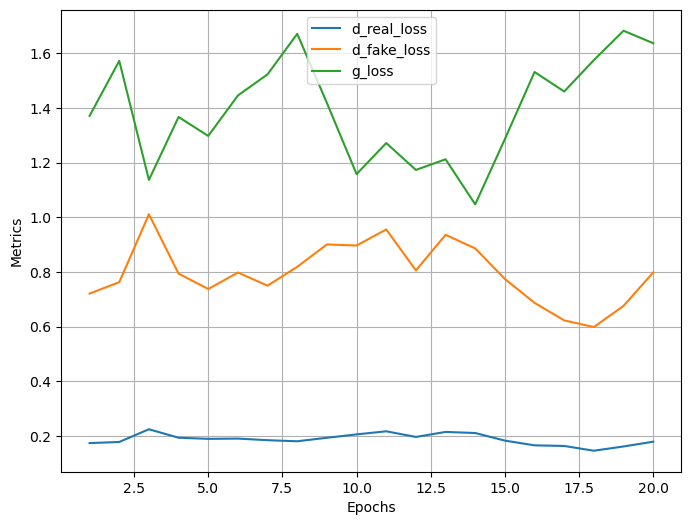

In [25]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 10
threshold = 2.3
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
loss_total = 0
num_batchs = 0
count = 0
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        g_d_loss = g_loss.item() + d_real.item() + d_fake.item()
        loss_total += g_d_loss
        num_batchs += 1
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(), total_loss = g_d_loss,
                   end = '\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        torch.save(generator.state_dict(),model_name+"/generator.pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
        count = 0
    else:
        count += 1
        if count >= 3:
            break
    loss_total = 0
    num_batchs = 0

log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])

In [26]:
d_optimizer = torch.optim.AdamW(discriminator.parameters(),lr=1e-4)
g_optimizer = torch.optim.AdamW(generator.parameters(),lr=4e-4)

EPOCH: 1.000  d_fake_loss: 0.754  d_loss: 0.936  g_loss: 1.395  d_real_loss: 0.183  (246.60s - 4685.42s remaining)
EPOCH: 2.000  d_fake_loss: 0.773  d_loss: 0.965  g_loss: 1.197  d_real_loss: 0.191  (493.27s - 4439.46s remaining)
EPOCH: 3.000  d_fake_loss: 0.992  d_loss: 1.215  g_loss: 1.176  d_real_loss: 0.223  (740.05s - 4193.64s remaining)
EPOCH: 4.000  d_fake_loss: 0.789  d_loss: 0.974  g_loss: 1.478  d_real_loss: 0.185  (987.02s - 3948.07s remaining)
EPOCH: 5.000  d_fake_loss: 0.823  d_loss: 1.022  g_loss: 1.278  d_real_loss: 0.200  (1233.60s - 3700.80s remaining)
EPOCH: 6.000  d_fake_loss: 0.730  d_loss: 0.914  g_loss: 1.319  d_real_loss: 0.184  (1480.08s - 3453.51s remaining)
EPOCH: 7.000  d_fake_loss: 0.721  d_loss: 0.901  g_loss: 1.263  d_real_loss: 0.180  (1726.56s - 3206.47s remaining)
EPOCH: 8.000  d_fake_loss: 0.552  d_loss: 0.691  g_loss: 1.863  d_real_loss: 0.138  (1973.19s - 2959.79s remaining)
EPOCH: 9.000  d_fake_loss: 0.574  d_loss: 0.713  g_loss: 1.916  d_real_loss:

100%|██████████| 121/121 [00:00<00:00, 606.97it/s]


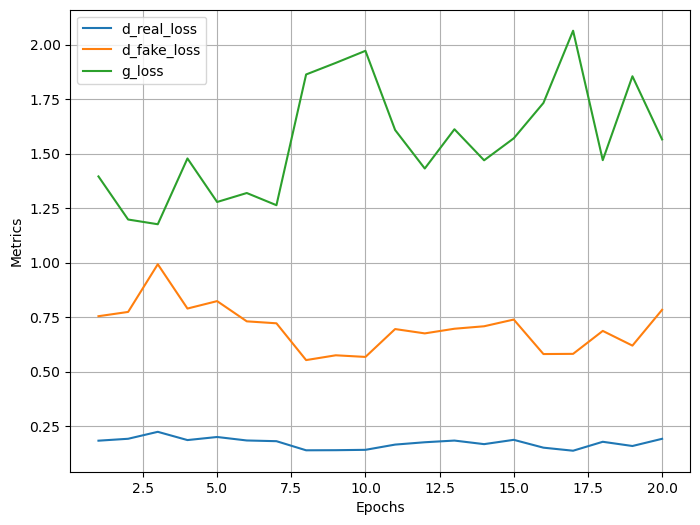

In [27]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 10
threshold = 2.3
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
loss_total = 0
num_batchs = 0
count = 0
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        g_d_loss = g_loss.item() + d_real.item() + d_fake.item()
        loss_total += g_d_loss
        num_batchs += 1
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(), total_loss = g_d_loss,
                   end = '\r')
    log.report_avgs(epoch+1)
    if (loss_total/num_batchs) < threshold:
        torch.save(generator.state_dict(),model_name+"/generator.pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")
        count = 0
    else:
        count += 1
        if count >= 3:
            break
    loss_total = 0
    num_batchs = 0

log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])

In [115]:
generator.to('cpu')
fake_data = generator(noise_generator('cpu',10,2048))
fake_data.shape

torch.Size([10, 3, 128, 128])

In [128]:
discriminator.to('cpu')
pred_fake = discriminator(fake_data).to('cpu')
print(pred_fake)
print(nn.Sigmoid()(pred_fake))
loss_fake = loss_fn(pred_fake,torch.ones((len(fake_data),1)))
print(loss_fake)

tensor([[-3.1258],
        [-3.3467],
        [-2.8095],
        [-3.7008],
        [-2.9497],
        [-3.3286],
        [-3.0424],
        [-3.1405],
        [-2.9816],
        [-3.4089]], grad_fn=<AddmmBackward0>)
tensor([[0.0421],
        [0.0340],
        [0.0568],
        [0.0241],
        [0.0498],
        [0.0346],
        [0.0455],
        [0.0415],
        [0.0483],
        [0.0320]], grad_fn=<SigmoidBackward0>)
tensor(3.2252, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [46]:
import torch.nn as nn
pred_fake2 = nn.Sigmoid()(pred_fake)
pred_fake2

tensor([[0.2186],
        [0.7382],
        [0.5298],
        [0.3523],
        [0.5619],
        [0.4709],
        [0.4200],
        [0.5763],
        [0.6403],
        [0.6327]], grad_fn=<SigmoidBackward0>)

In [102]:
sample = fake_data[0:4]
#sample = sample.unsqueeze(0)
sample.shape

torch.Size([4, 3, 128, 128])

In [103]:
pred_sample = discriminator(sample).to('cpu')
print(pred_sample)
print(nn.Sigmoid()(pred_sample))
loss_sample = loss_fn(pred_sample,torch.ones((len(sample),1)))
print(loss_sample)

tensor([[-5.3137],
        [-4.3341],
        [-3.0179],
        [-5.0070]], grad_fn=<AddmmBackward0>)
tensor([[0.0049],
        [0.0129],
        [0.0466],
        [0.0066]], grad_fn=<SigmoidBackward0>)
tensor(4.4363, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


tensor(4.8540, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

tensor([[0.0009]], grad_fn=<SigmoidBackward0>)


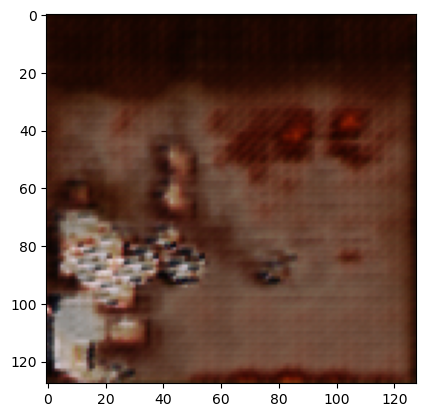

In [106]:
img = fake_data[0]
print(torch.nn.Sigmoid()(discriminator(img.unsqueeze(0))))
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

In [33]:
p = 0
while p < 0.5:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

KeyboardInterrupt: 

0.9233351349830627

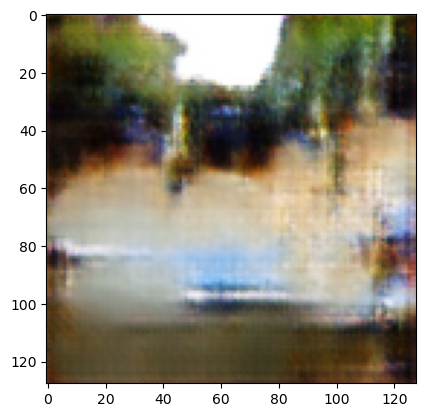

In [ ]:
p = 0
while p < 0.7:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

0.9158802628517151

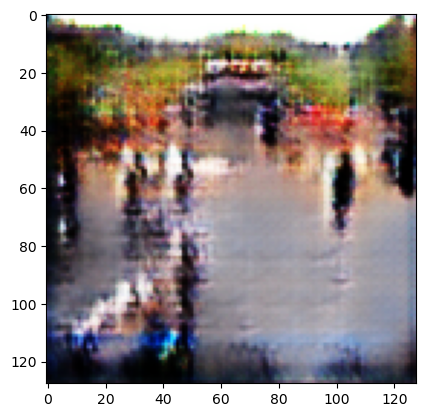

In [ ]:
p = 0
while p < 0.9:
    img = generator(noise_generator(device,1,2048)).to(device)
    p = torch.nn.Sigmoid()(discriminator(img))[0][0]
print(p.item())
img = img.detach().cpu().numpy()
img2 = img.squeeze()
img2 = img2.transpose(1,2,0)
plt.imshow(img2)

In [ ]:
N = len(train_dataloader)
noise_dim = 2048
num_epochs = 8
log = Report(num_epochs)
generator.to(device)
discriminator.to(device)
for epoch in range(num_epochs):
    for i, images in enumerate(train_dataloader):
        real_data = images.to(device)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        fake_data = fake_data.detach()
        d_real, d_fake = train_discriminator(discriminator,real_data,fake_data,
                                     loss_fn,d_optimizer)
        fake_data = generator(noise_generator(device,batch_size,noise_dim)).to(device)
        g_loss = train_generator(discriminator,fake_data,loss_fn,g_optimizer)
        log.record(epoch+(1+i)/N, g_loss=g_loss.item(), d_loss = d_real.item() + d_fake.item(),
                   d_real_loss=d_real.item(), d_fake_loss=d_fake.item(),
                   end = '\r')
    log.report_avgs(epoch+1)
    if g_loss < 2:
        torch.save(generator.state_dict(),model_name+"/generator.pth")
        torch.save(discriminator.state_dict(),model_name+"/discriminator.pth")

log.plot_epochs(['d_real_loss','d_fake_loss','g_loss'])